In [117]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass

Observe que cuando la distancia entre 2 cuerpos es muy pequeña la fuerza tiende a infinito, ya que esta es de la forma

$$
\vec{F} = -\frac{GMm}{|\vec{r_2}-\vec{r_1}|^3}(\vec{ r_2 } - \vec{ r_1 })
$$

Para resolver esto implementaremos una tecnica llamada **_gravitational softening_** la cual consiste en calcular la fuerza como

$$
\vec{F} = -\frac{GMm}{(|\vec{r_2}-\vec{r_1}|^2 + \varepsilon^2)^{3/2}}(\vec{ r_2 } - \vec{ r_1 })
$$

Referencias:

[Gravitational softening as a smoothing operation](https://arxiv.org/abs/1205.2729)


In [118]:
G = 6.67430e-11


def three_body_system_for_solve_ivp(t, state, m1, m2, m3, gravitational_softening=1e-2):
    """
    Calculate the time derivative for every member of the sate vector for the three-body problem
    for the solve_ivp method.

    state: 18 elements array with the following structure (Those are instantaneous
    values of the position and velocity of each of the three bodies),
       [x1, y1, z1, vx1, vy1, vz1,
        x2, y2, z2, vx2, vy2, vz2,
        x3, y3, z3, vx3, vy3, vz3]
    t: time (required by solve_ivp method)
    m1, m2, m3: masses of the three bodies
    gravitational_softening: a small value to avoid division by zero in the gravitational force calculation
    """
    x1, y1, z1, vx1, vy1, vz1, x2, y2, z2, vx2, vy2, vz2, x3, y3, z3, vx3, vy3, vz3 = (
        state
    )

    r1 = np.array([x1, y1, z1])
    r2 = np.array([x2, y2, z2])
    r3 = np.array([x3, y3, z3])

    r12 = r2 - r1
    r13 = r3 - r1
    r23 = r3 - r2

    d12 = np.sqrt(np.linalg.norm(r12) ** 2 + gravitational_softening**2)
    d13 = np.sqrt(np.linalg.norm(r13) ** 2 + gravitational_softening**2)
    d23 = np.sqrt(np.linalg.norm(r23) ** 2 + gravitational_softening**2)

    a1 = G * m2 * r12 / d12**3 + G * m3 * r13 / d13**3
    a2 = G * m1 * (-r12) / d12**3 + G * m3 * r23 / d23**3
    a3 = G * m1 * (-r13) / d13**3 + G * m2 * (-r23) / d23**3

    return [
        vx1,
        vy1,
        vz1,
        a1[0],
        a1[1],
        a1[2],
        vx2,
        vy2,
        vz2,
        a2[0],
        a2[1],
        a2[2],
        vx3,
        vy3,
        vz3,
        a3[0],
        a3[1],
        a3[2],
    ]


def three_body_system_for_leap_frog(
    state, m1, m2, m3, dt, gravitational_softening=1e-2
):
    x1, y1, z1, vx1, vy1, vz1, x2, y2, z2, vx2, vy2, vz2, x3, y3, z3, vx3, vy3, vz3 = (
        state
    )

    r1 = np.array([x1, y1, z1])
    r2 = np.array([x2, y2, z2])
    r3 = np.array([x3, y3, z3])

    r12 = r2 - r1
    r13 = r3 - r1
    r23 = r3 - r2

    d12 = np.sqrt(np.linalg.norm(r12) ** 2 + gravitational_softening**2)
    d13 = np.sqrt(np.linalg.norm(r13) ** 2 + gravitational_softening**2)
    d23 = np.sqrt(np.linalg.norm(r23) ** 2 + gravitational_softening**2)

    a1 = G * m2 * r12 / d12**3 + G * m3 * r13 / d13**3
    a2 = G * m1 * (-r12) / d12**3 + G * m3 * r23 / d23**3
    a3 = G * m1 * (-r13) / d13**3 + G * m2 * (-r23) / d23**3

    v1_half_dt = np.array([vx1, vy1, vz1]) + 0.5 * a1 * dt
    v2_half_dt = np.array([vx2, vy2, vz2]) + 0.5 * a2 * dt
    v3_half_dt = np.array([vx3, vy3, vz3]) + 0.5 * a3 * dt

    r1_dt = r1 + v1_half_dt * dt
    r2_dt = r2 + v2_half_dt * dt
    r3_dt = r3 + v3_half_dt * dt

    r12_new = r2_dt - r1_dt
    r13_new = r3_dt - r1_dt
    r23_new = r3_dt - r2_dt

    d12_new = np.sqrt(np.linalg.norm(r12_new) ** 2 + gravitational_softening**2)
    d13_new = np.sqrt(np.linalg.norm(r13_new) ** 2 + gravitational_softening**2)
    d23_new = np.sqrt(np.linalg.norm(r23_new) ** 2 + gravitational_softening**2)

    a1_new = G * m2 * r12_new / d12_new**3 + G * m3 * r13_new / d13_new**3
    a2_new = G * m1 * (-r12_new) / d12_new**3 + G * m3 * r23_new / d23_new**3
    a3_new = G * m1 * (-r13_new) / d13_new**3 + G * m2 * (-r23_new) / d23_new**3

    v1_dt = v1_half_dt + 0.5 * a1_new * dt
    v2_dt = v2_half_dt + 0.5 * a2_new * dt
    v3_dt = v3_half_dt + 0.5 * a3_new * dt

    return np.concatenate((r1_dt, v1_dt, r2_dt, v2_dt, r3_dt, v3_dt))


In [119]:
from pythreejs import *
from IPython.display import display


@dataclass
class ThreeBodySolution:
    """This dataClass represents the solution of the three-body problem"""

    x1: np.ndarray
    y1: np.ndarray
    z1: np.ndarray
    vx1: np.ndarray
    vy1: np.ndarray
    vz1: np.ndarray
    x2: np.ndarray
    y2: np.ndarray
    z2: np.ndarray
    vx2: np.ndarray
    vy2: np.ndarray
    vz2: np.ndarray
    x3: np.ndarray
    y3: np.ndarray
    z3: np.ndarray
    vx3: np.ndarray
    vy3: np.ndarray
    vz3: np.ndarray


def solve_three_body_problem_solve_ivp(
    m1, m2, m3, state0, t, gs=1e-2
) -> ThreeBodySolution:
    """
    Solve the three body problem for the given masses and initial conditions

    state0: 18 elements array with the following structure (Those are instantaneous
    values of the position and velocity of each of the three bodies),
       [x1, y1, z1, vx1, vy1, vz1,
        x2, y2, z2, vx2, vy2, vz2,
        x3, y3, z3, vx3, vy3, vz3]
    m1, m2, m3: masses of the three bodies
    t: time (required by solve_ivp method)
    """
    solution = solve_ivp(
        three_body_system_for_solve_ivp,
        (t[0], t[-1]),
        state0,
        args=(m1, m2, m3, gs),
        t_eval=t,
        method="DOP853",
        rtol=1e-9,
        atol=1e-12,
    )
    return ThreeBodySolution(
        x1=solution.y[0],
        y1=solution.y[1],
        z1=solution.y[2],
        vx1=solution.y[3],
        vy1=solution.y[4],
        vz1=solution.y[5],
        x2=solution.y[6],
        y2=solution.y[7],
        z2=solution.y[8],
        vx2=solution.y[9],
        vy2=solution.y[10],
        vz2=solution.y[11],
        x3=solution.y[12],
        y3=solution.y[13],
        z3=solution.y[14],
        vx3=solution.y[15],
        vy3=solution.y[16],
        vz3=solution.y[17],
    )


def solve_three_body_problem_leap_frog(m1, m2, m3, state0, dt, steps, gs=1e-2):

    trajectory = np.zeros((steps, len(state0)), dtype=np.float64)
    trajectory[0] = state0

    for i in range(1, steps):
        trajectory[i] = three_body_system_for_leap_frog(
            trajectory[i - 1], m1, m2, m3, dt, gs
        )

    return ThreeBodySolution(
        x1=trajectory[:, 0],
        y1=trajectory[:, 1],
        z1=trajectory[:, 2],
        vx1=trajectory[:, 3],
        vy1=trajectory[:, 4],
        vz1=trajectory[:, 5],
        x2=trajectory[:, 6],
        y2=trajectory[:, 7],
        z2=trajectory[:, 8],
        vx2=trajectory[:, 9],
        vy2=trajectory[:, 10],
        vz2=trajectory[:, 11],
        x3=trajectory[:, 12],
        y3=trajectory[:, 13],
        z3=trajectory[:, 14],
        vx3=trajectory[:, 15],
        vy3=trajectory[:, 16],
        vz3=trajectory[:, 17],
    )


def plot_projection_three_body_solution(solution: ThreeBodySolution, title: str):
    """
    Plot the solution of the three-body problem on the XY plane
    """
    plt.figure(figsize=(10, 10))
    plt.plot(solution.x1, solution.y1, ".", markersize=1, label="Cuerpo 1")
    plt.plot(solution.x2, solution.y2, ".", markersize=1, label="Cuerpo 2")
    plt.plot(solution.x3, solution.y3, ".", markersize=1, label="Cuerpo 3")
    plt.title(title)
    plt.legend()
    plt.show()


def plot_three_body_solution(solution: ThreeBodySolution, title: str):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    x1, y1, z1 = solution.x1, solution.y1, solution.z1
    x2, y2, z2 = solution.x2, solution.y2, solution.z2
    x3, y3, z3 = solution.x3, solution.y3, solution.z3

    ax.plot(x1, y1, z1, ".", markersize=1, label="Cuerpo 1")
    ax.plot(x2, y2, z2, ".", markersize=1, label="Cuerpo 2")
    ax.plot(x3, y3, z3, ".", markersize=1, label="Cuerpo 3")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)
    ax.legend()
    plt.show()


def calculate_mechanical_energy(solution: ThreeBodySolution, m1, m2, m3, num_points, t):
    potential_energy = np.zeros(num_points)
    kinetic_energy = np.zeros(num_points)

    for i in range(num_points):
        r1 = np.array([solution.x1[i], solution.y1[i], solution.z1[i]])
        r2 = np.array([solution.x2[i], solution.y2[i], solution.z2[i]])
        r3 = np.array([solution.x3[i], solution.y3[i], solution.z3[i]])

        v1 = np.array([solution.vx1[i], solution.vy1[i], solution.vz1[i]])
        v2 = np.array([solution.vx2[i], solution.vy2[i], solution.vz2[i]])
        v3 = np.array([solution.vx3[i], solution.vy3[i], solution.vz3[i]])

        potential_energy[i] = -G * (
            m1 * m2 / np.linalg.norm(r2 - r1)
            + m1 * m3 / np.linalg.norm(r3 - r1)
            + m2 * m3 / np.linalg.norm(r3 - r2)
        )
        kinetic_energy[i] = 0.5 * (
            m1 * np.linalg.norm(v1) ** 2
            + m2 * np.linalg.norm(v2) ** 2
            + m3 * np.linalg.norm(v3) ** 2
        )

    total_energy = potential_energy + kinetic_energy

    plt.figure(figsize=(10, 6))
    plt.plot(t, total_energy, color="green", label="Energía mecanica numerica")
    plt.axhline(
        y=np.mean(potential_energy + kinetic_energy),
        color="r",
        linestyle="--",
        label="E promedio",
    )
    plt.axhline(y=total_energy[0], color="b", linestyle="--", label="E inicial")
    plt.legend()
    plt.grid(True)
    plt.ylabel("Energía $[J]$")
    plt.xlabel("Tiempo $[S]$")
    plt.title("Energía Mecánica del sistema")
    plt.show()

    relative_error = np.abs(total_energy - total_energy[0]) 
    plt.figure(figsize=(10, 6))
    plt.plot(t, relative_error, label="Error Relativo de Energía", color="r")
    plt.yscale("log")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Error Relativo $\\frac{|E - E_0|}{|E_0|}$")
    plt.title("Evolución del Error Relativo en la Energía Mecánica")
    plt.legend()
    plt.grid(True)
    plt.show()

# Runge-Kutta based solution

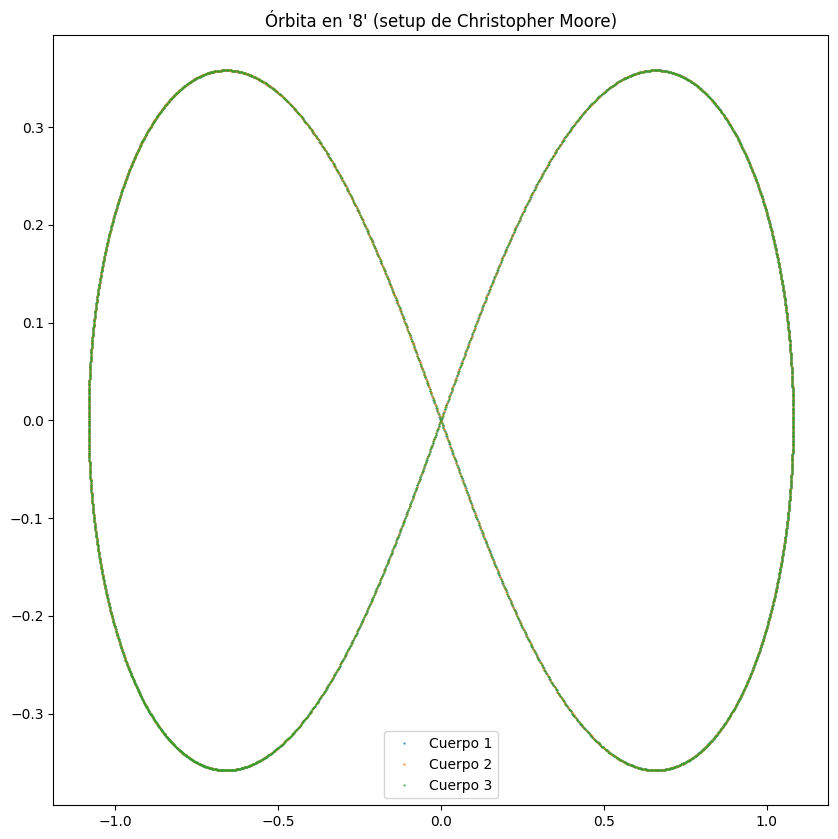

In [120]:
# ----------------------
# System parameters
# ----------------------

G = 1.0  # Gravitational constant normalized
m1 = m2 = m3 = 1.0

# ----------------------------
# Initial conditions
# ----------------------------

r1 = np.array([0.97000436, -0.24308753, 0.0])
r2 = np.array([-0.97000436, 0.24308753, 0.0])
r3 = np.array([0.0, 0.0, 0.0])

v1 = np.array([0.4662036850, 0.43236573, 0.0])
v2 = np.array([0.4662036850, 0.43236573, 0.0])
v3 = np.array([-0.93240737, -0.86473146, 0.0])

state0 = np.concatenate((r1, v1, r2, v2, r3, v3))
t_max = 20
num_points = 2000
t = np.linspace(0, t_max, num_points)

# ----------------------------
# Solve the system
# ----------------------------
sol = solve_three_body_problem_solve_ivp(m1, m2, m3, state0, t, 0)
plot_projection_three_body_solution(sol, "Órbita en '8' (setup de Christopher Moore)")

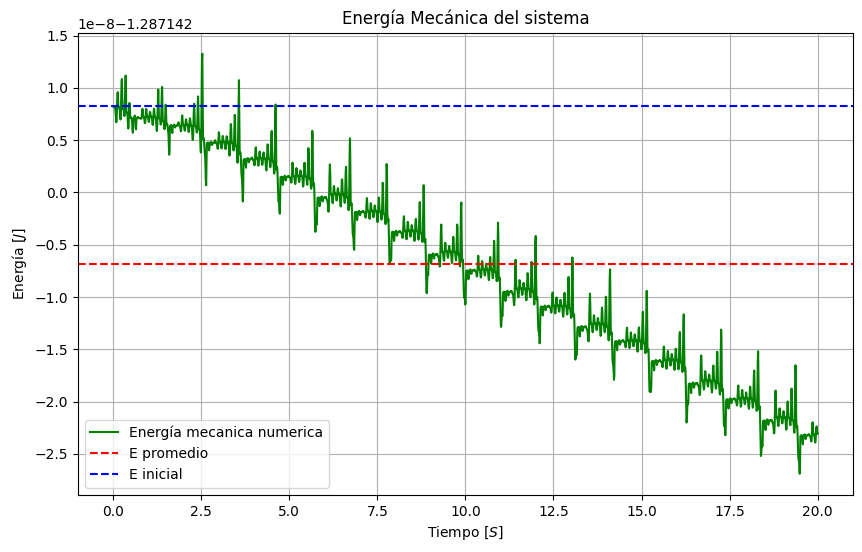

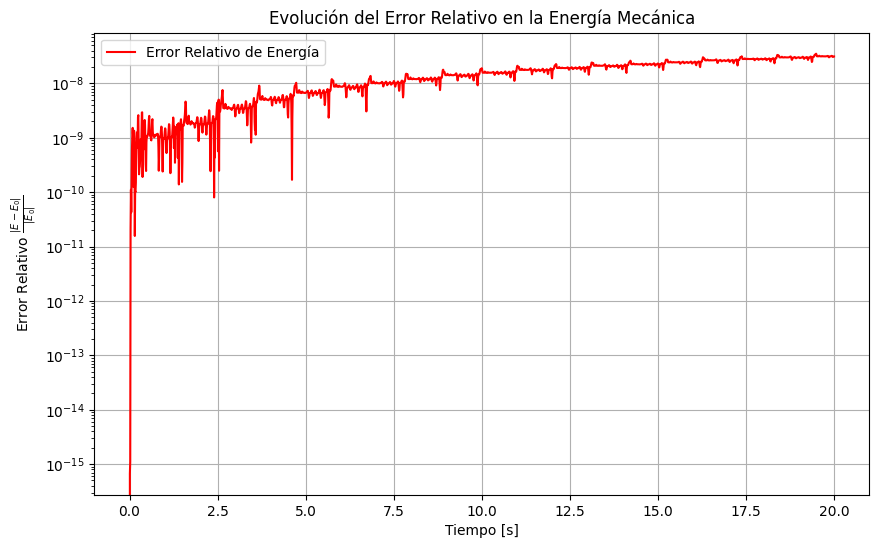

In [121]:
calculate_mechanical_energy(sol, m1, m2, m3, num_points, t)

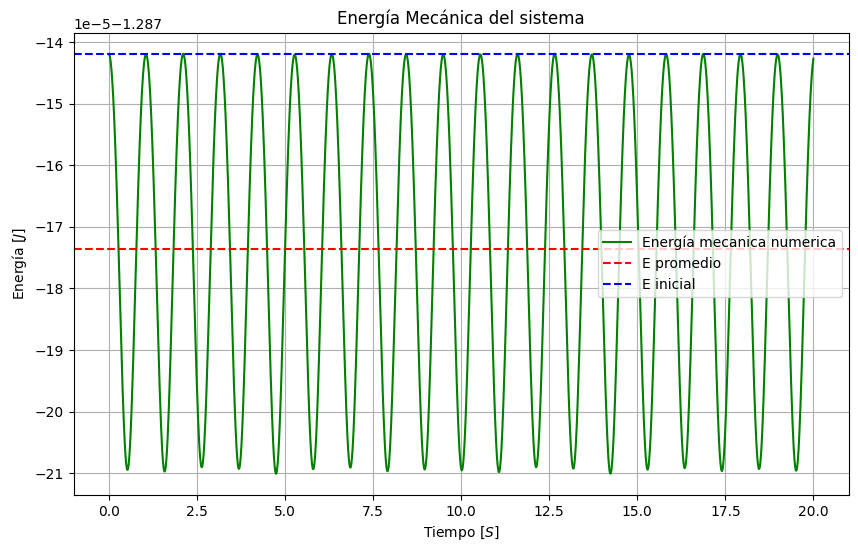

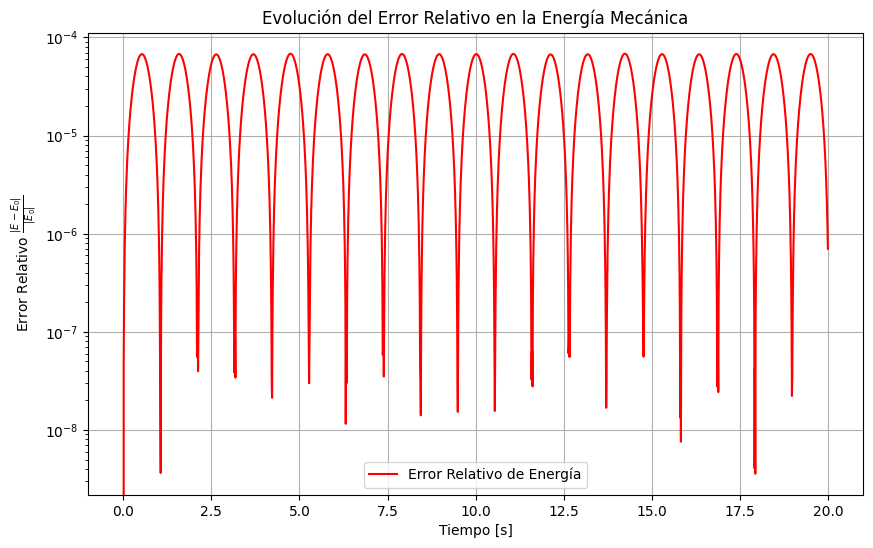

In [122]:
sol = solve_three_body_problem_solve_ivp(m1, m2, m3, state0, t, 1e-2)
calculate_mechanical_energy(sol, m1, m2, m3, num_points, t)

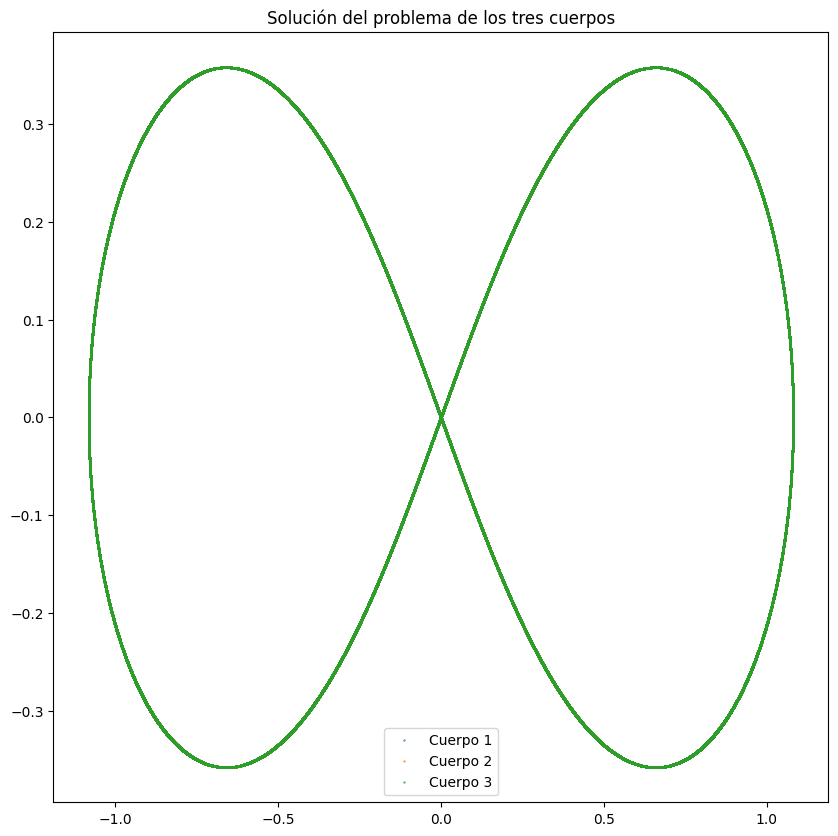

In [123]:
# ----------------------
# System parameters
# ----------------------

G = 1.0  # Gravitational constant normalized
m1 ,m2 , m3 = 1, 1, 1

# ----------------------------
# Initial conditions
# ----------------------------

r1 = np.array([0.97000436, -0.24308753, 0.0])
r2 = np.array([-0.97000436, 0.24308753, 0.0])
r3 = np.array([0.0, 0.0, 0.0])

v1 = np.array([0.4662036850, 0.43236573, 0.0])
v2 = np.array([0.4662036850, 0.43236573, 0.0])
v3 = np.array([-0.93240737, -0.86473146, 0.0])

state0 = np.concatenate((r1, v1, r2, v2, r3, v3))
dt=0.0005
steps=200000


sol = solve_three_body_problem_leap_frog(m1, m2, m3, state0, dt, steps, 0)

plot_projection_three_body_solution(sol, "Solución del problema de los tres cuerpos")


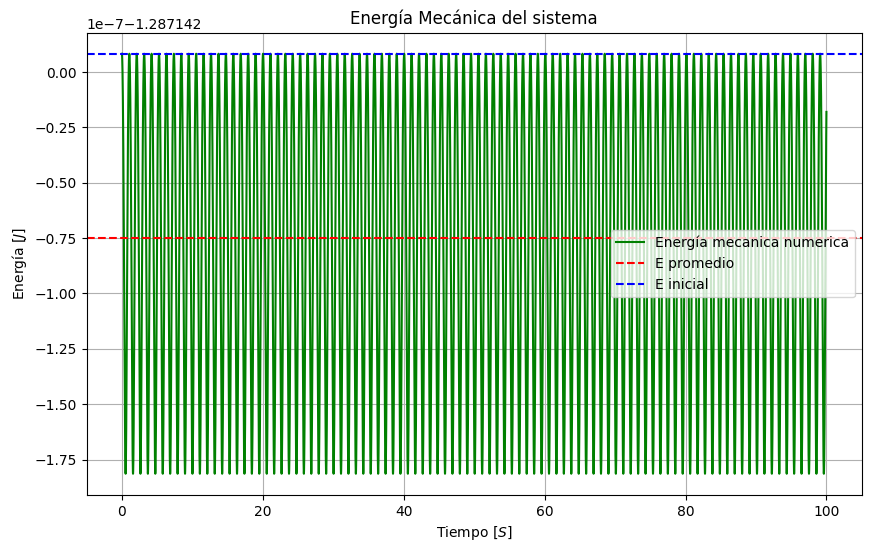

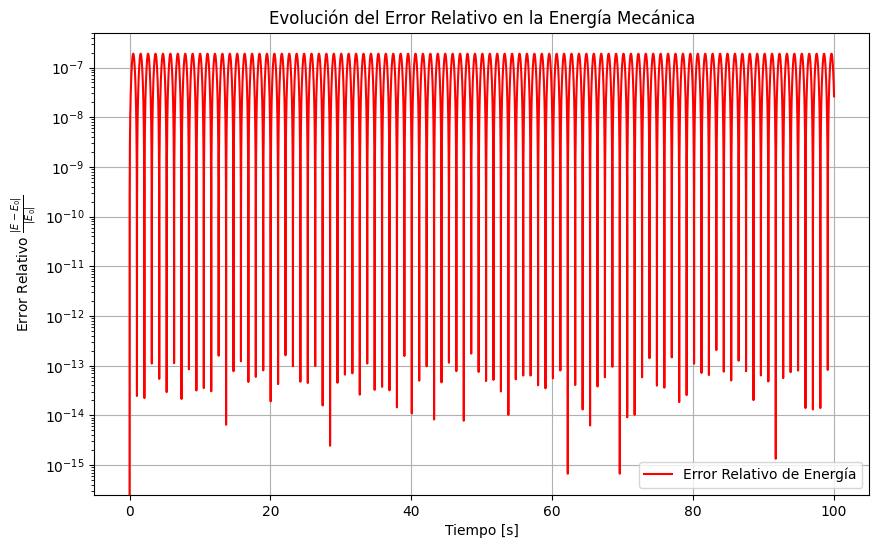

In [124]:
num_points = len(sol.x1)
t = np.arange(0, num_points) * dt
calculate_mechanical_energy(sol, m1, m2, m3, num_points, t)

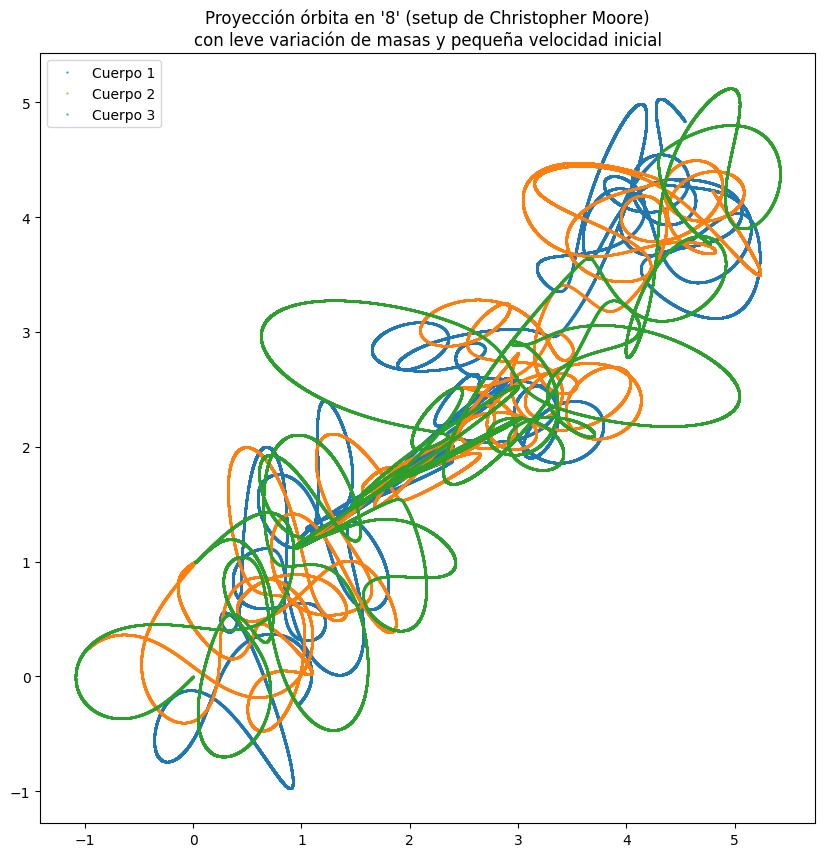

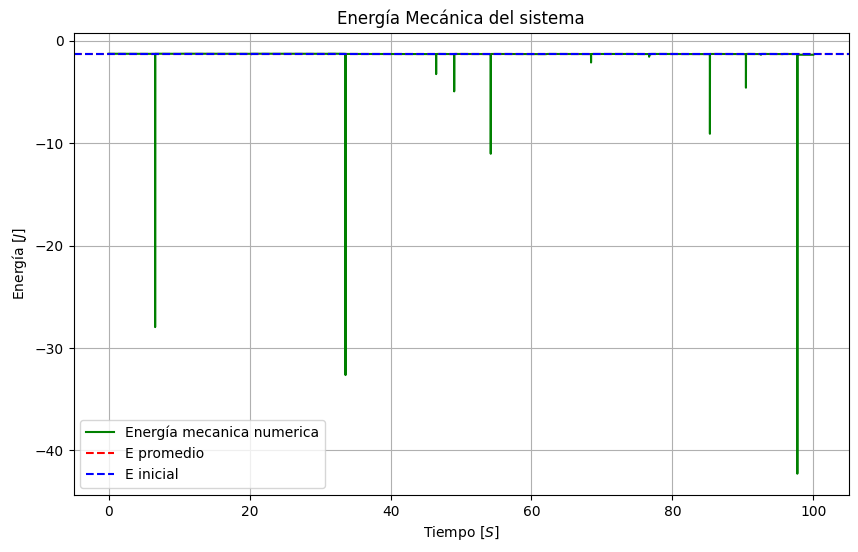

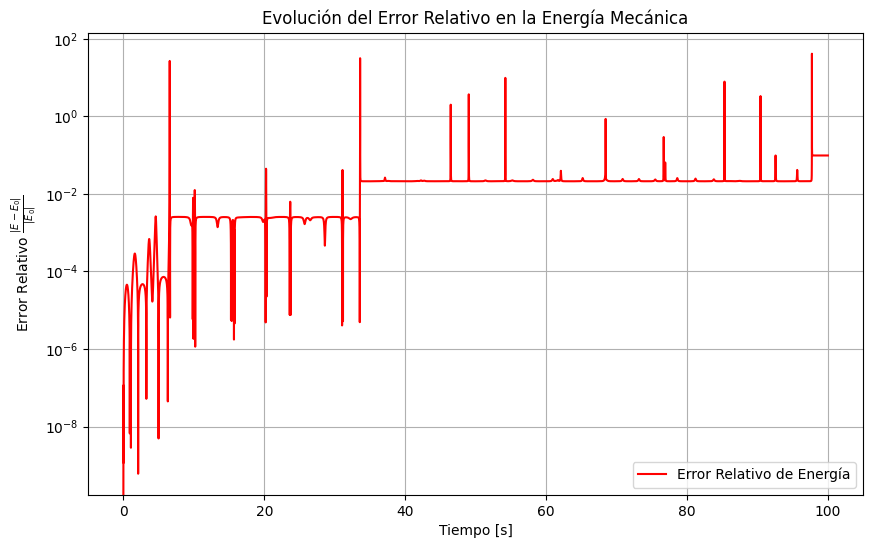

In [125]:
# ----------------------
# System parameters
# ----------------------

G = 1.0  # Gravitational constant normalized
m1 = 1.1
m2 = 1
m3 = 0.9

# ----------------------------
# Initial conditions
# ----------------------------

r1 = np.array([0.97000436, -0.24308753, 0.0])
r2 = np.array([-0.97000436, 0.24308753, 0.0])
r3 = np.array([0.0, 0.0, 0.0])

v1 = np.array([0.4662036850, 0.43236573, 0.1])
v2 = np.array([0.4662036850, 0.43236573, 0.0])
v3 = np.array([-0.93240737, -0.86473146, 0.2])

state0 = np.concatenate((r1, v1, r2, v2, r3, v3))




# ----------------------------
# Solve the system
# ----------------------------

sol = solve_three_body_problem_leap_frog(m1, m2, m3, state0, dt, steps, 1e-2)
plot_projection_three_body_solution(
    sol,
    "Proyección órbita en '8' (setup de Christopher Moore)\ncon leve variación de masas y pequeña velocidad inicial",
)
# plot_three_body_solution(
#     sol,
#     "Órbita en '8' (setup de Christopher Moore)\ncon leve variación de masas y pequeña velocidad inicial",
# )

calculate_mechanical_energy(sol, m1, m2, m3, len(sol.x1), np.arange(0, num_points) * dt)


# sol = solve_three_body_problem_solve_ivp(m1, m2, m3, state0, t, 1e-3)
# plot_projection_three_body_solution(
#     sol,
#     "Proyección órbita en '8' (setup de Christopher Moore)\ncon leve variación de masas y pequeña velocidad inicial",
# )
# plot_three_body_solution(
#     sol,
#     "Órbita en '8' (setup de Christopher Moore)\ncon leve variación de masas y pequeña velocidad inicial",
# )



In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from scipy.interpolate import interp1d

G = 1.0  # Constante gravitacional normalizada
m1, m2, m3 = 1, 1, 1

# Condiciones iniciales
r1 = np.array([0.97000436, -0.24308753, 0.0])
r2 = np.array([-0.97000436, 0.24308753, 0.0])
r3 = np.array([0.0, 0.0, 0.0])

v2 = np.array([ 0.4662036850,  0.43236573,  0.0])
v3 = np.array([-0.93240737 , -0.86473146,  0.0])


# Parámetros de tiempo
t_max = 200
num_points = 10000
t = np.linspace(0, t_max, num_points)


# Generar diferentes velocidades iniciales para v1
velocities = np.random.uniform(-1, 1, (1000, 3))  # 1000 velocidades aleatorias en 3D

def compute_single_poincare(velocity):
    """
    Computa la sección de Poincaré para una condición inicial dada.
    """
    v1 = np.array(velocity)
    state0 = np.concatenate((r1, v1, r2, v2, r3, v3))
    
    # Resolver el problema de tres cuerpos con Leapfrog o Solve_ivp
    solution = solve_three_body_problem_leap_frog(m1, m2, m3, state0, dt, steps, 1e-2)

    y1 = solution.y1
    vy1 = solution.vy1
    x1 = solution.x1
    vx1 = solution.vx1

    # Buscar cruces en y=0 con vy > 0 (Interpolación)
    poincare_points = []
    for i in range(len(y1) - 1):
        if y1[i] < 0 and y1[i+1] > 0 and vy1[i] > 0 and vy1[i+1] > 0:

            # Interpolación lineal para encontrar el punto exacto donde y=0
            f_interp = interp1d([y1[i], y1[i+1]], [x1[i], x1[i+1]], kind="linear")
            x_poincare = f_interp(0)  # Encontrar x cuando y=0
            
            f_interp_vx = interp1d([y1[i], y1[i+1]], [vx1[i], vx1[i+1]], kind="linear")
            vx_poincare = f_interp_vx(0)  # Encontrar vx cuando y=0

            poincare_points.append((x_poincare, vx_poincare))

    return poincare_points

def compute_poincare_section_parallel():
    """
    Ejecuta la simulación en paralelo usando multiprocessing.
    """
    num_workers = cpu_count()  # Evita usar demasiados procesos
    print(f"Usando {num_workers} núcleos para la simulación...")

    with Pool(num_workers) as pool:
        results = list(tqdm(pool.imap(compute_single_poincare, velocities), total=len(velocities)))

    # Convertir lista de listas en arrays
    x_poincare, vx_poincare = [], []
    for points in results:
        for x, vx in points:
            x_poincare.append(x)
            vx_poincare.append(vx)

    return np.array(x_poincare), np.array(vx_poincare)

def plot_poincare_section(x_poincare, vx_poincare):
    """
    Genera el diagrama de Poincaré con los puntos de intersección.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(x_poincare, vx_poincare, s=2, color="blue", alpha=0.6)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$v_x$")
    plt.title("Diagrama de Poincaré - Problema de Tres Cuerpos")
    plt.grid()
    plt.show()

def save_poincare_to_csv(x_poincare, vx_poincare, filename="poincare_data.csv"):
    """
    Guarda los datos de la sección de Poincaré en un archivo CSV.
    """
    df = pd.DataFrame({"x": x_poincare, "vx": vx_poincare})
    df.to_csv(filename, index=False)
    print(f"Datos guardados en {filename}")

# Ejecutar la simulación en paralelo
x_poincare, vx_poincare = compute_poincare_section_parallel()

# Guardar los datos en CSV
save_poincare_to_csv(x_poincare, vx_poincare)

# Graficar la sección de Poincaré
plot_poincare_section(x_poincare, vx_poincare)


Usando 20 núcleos para la simulación...


  0%|          | 0/1000 [00:22<?, ?it/s]


KeyboardInterrupt: 

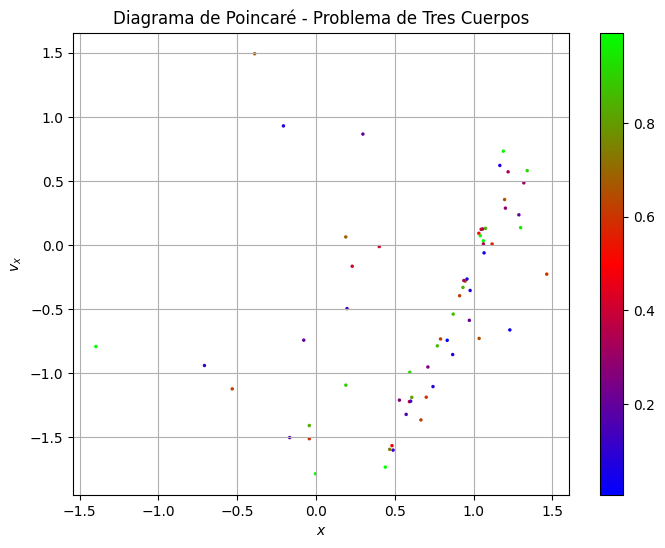

In [12]:
def plot_poincare_from_csv(filename="poincare_data.csv", x_range=(-2, 2), vx_range=(-2, 2)):
    """
    Carga datos de un CSV y grafica la sección de Poincaré.
    """
    df = pd.read_csv(filename)
    df["color"] = np.random.uniform(0, 1, len(df))
    df_filtered = df
    df_filtered = df[(df["x"] >= x_range[0]) & (df["x"] <= x_range[1]) &
                     (df["vx"] >= vx_range[0]) & (df["vx"] <= vx_range[1])]
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df_filtered["x"], df_filtered["vx"], c=df_filtered["color"], cmap="brg", marker=".", s=25, edgecolor='none')
    cbar = plt.colorbar(scatter)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$v_x$")
    plt.title("Diagrama de Poincaré - Problema de Tres Cuerpos")
    plt.grid()
    plt.show()

# Cargar y graficar datos desde CSV
plot_poincare_from_csv()
